# Applying flat-field corrections

`opticam_new` provides a simple interface for creating and applying image corrections (currently limited to flat-field corrections). In this notebook, I will demonstrate how to create a master flat, and how this master flat can be incorporated into the reduction process.

## Creating synthetic flats

Before applying flat-field corrections, we need some flat-field images. For this tutorial, I will use the `create_synthetic_flats()` routine from `opticam_new.generate` which will create five flat-field images for each camera. These images will be saved to a user specified directory, which will be created if it does not already exist:

In [1]:
from opticam_new.generate import create_synthetic_flats

create_synthetic_flats(out_dir='flats', overwrite=True)  # generate some synthetic flats

Let's check if our newly created flats are where they should be:

In [2]:
import os

flats = sorted(os.listdir('flats'))
for file in flats:
    print(file)

g-band_flat_0.fits.gz
g-band_flat_1.fits.gz
g-band_flat_2.fits.gz
g-band_flat_3.fits.gz
g-band_flat_4.fits.gz
i-band_flat_0.fits.gz
i-band_flat_1.fits.gz
i-band_flat_2.fits.gz
i-band_flat_3.fits.gz
i-band_flat_4.fits.gz
r-band_flat_0.fits.gz
r-band_flat_1.fits.gz
r-band_flat_2.fits.gz
r-band_flat_3.fits.gz
r-band_flat_4.fits.gz


As we can see, each filter has the expected five flat field images. Let's take a look at one of these images:

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  256                                                  
NAXIS2  =                  256                                                  
EXTEND  =                    T                                                  
FILTER  = 'g       '                                                            
BINNING = '8x8     '                                                            
GAIN    =                  1.0                                                  
UT      = '2024-01-01 00:00:00'                                                 


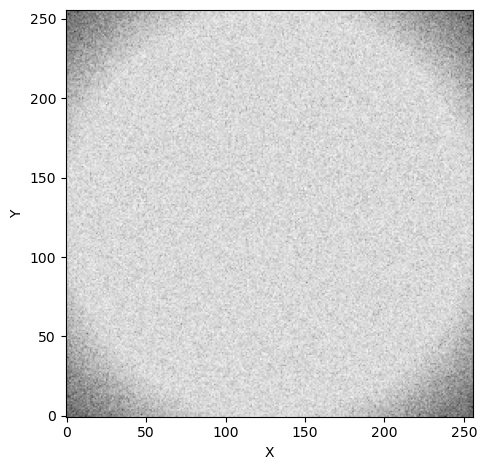

In [3]:
from astropy.io import fits
from astropy.visualization import simple_norm
from matplotlib import pyplot as plt
import numpy as np

file = flats[0]

with fits.open(f'flats/{file}') as hdul:
    print(repr(hdul[0].header))
    image = np.array(hdul[0].data)

fig, ax = plt.subplots(tight_layout=True)

im = ax.imshow(image, norm=simple_norm(image, stretch="sqrt"), origin="lower", cmap="Greys_r")

ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

For these synthetic flats, the shadow due to the telescope's circular aperture is captured. We also see this shadow in the synthetic observations created by `opticam_new.generate.create_synthetic_observations()`:

Creating synthetic observations: 100%|██████████| 100/100 [00:12<00:00,  7.71it/s]


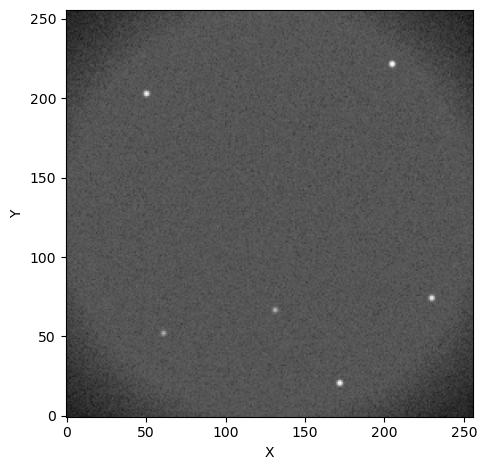

In [4]:
from opticam_new.generate import create_synthetic_observations

create_synthetic_observations(out_dir='data', overwrite=True)  # generate some synthetic observations

files = sorted(os.listdir('data'))
file = files[0]

with fits.open(f"data/{file}") as hdul:
    image = np.array(hdul[0].data)

fig, ax = plt.subplots(tight_layout=True)

im = ax.imshow(image, norm=simple_norm(image, stretch="sqrt"), origin="lower", cmap="Greys_r")

ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

## Applying flat-field corrections

In `opticam_new`, flat-field corrections are handled by the `FlatFieldCorrector` object. Like `Reducer`, `FlatFieldCorrector` will split flats by filter if they are all stored in a single directory, or separate directories can be specified for each filter's flats. In this example, all flats are stored in a single directory:

In [5]:
from opticam_new import FlatFieldCorrector

flat_corrector = FlatFieldCorrector(out_dir='master_flats', flats_dir='flats')

When defining a `FlatFieldCorrector` object, an `out_dir` must be specified. This is the directory to which any output files (like master flats) will be written. Now that we have a `FlatFieldCorrector` object, we can either create master flats manually, or pass the `FlatFieldCorrector` object to `Reducer`, and let the master flat creation be handled automatically. In this example, I will create the master flats manually:

In [6]:
flat_corrector.create_master_flats(overwrite=True)

Let's take a look at these master flats:

In [7]:
flats = sorted(os.listdir('master_flats/master_flats'))
for file in flats:
    print(file)

g-band_master_flat.fit.gz
i-band_master_flat.fit.gz
r-band_master_flat.fit.gz


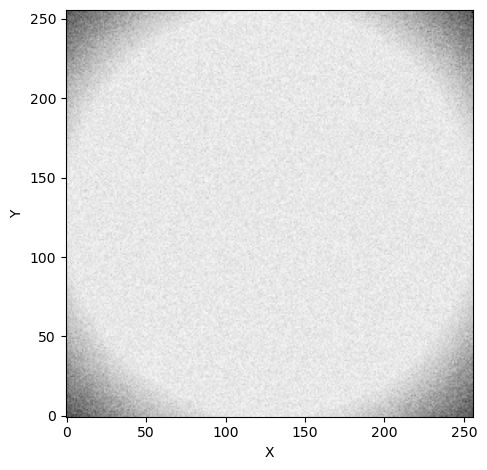

In [8]:
with fits.open(f"master_flats/master_flats/{flats[0]}") as hdul:
    image = np.array(hdul[0].data)

fig, ax = plt.subplots(tight_layout=True)

im = ax.imshow(image, norm=simple_norm(image, stretch="sqrt"), origin="lower", cmap="Greys_r")

ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

We can see that each filter now has one master flat file, which is also gzipped by default to reduce disk space. To apply flat-field corrections to OPTICAM images, we can now pass our `FlatFieldCorrector` object to `Reducer`:

[OPTICAM] Scanning data directory:   0%|          | 0/300 [00:00<?, ?it/s]

[OPTICAM] Done.
[OPTICAM] Binning: 8x8
[OPTICAM] Filters: g-band, r-band, i-band
[OPTICAM] Read g-band catalog from file.
[OPTICAM] Read r-band catalog from file.
[OPTICAM] Read i-band catalog from file.
[OPTICAM] Initialising catalogs ...


[OPTICAM] Aligning g-band images:   0%|          | 0/100 [00:00<?, ?it/s]

[OPTICAM] Done. 0 image(s) could not be aligned.


[OPTICAM] Aligning r-band images:   0%|          | 0/100 [00:00<?, ?it/s]

[OPTICAM] Done. 0 image(s) could not be aligned.


[OPTICAM] Aligning i-band images:   0%|          | 0/100 [00:00<?, ?it/s]

[OPTICAM] Done. 0 image(s) could not be aligned.


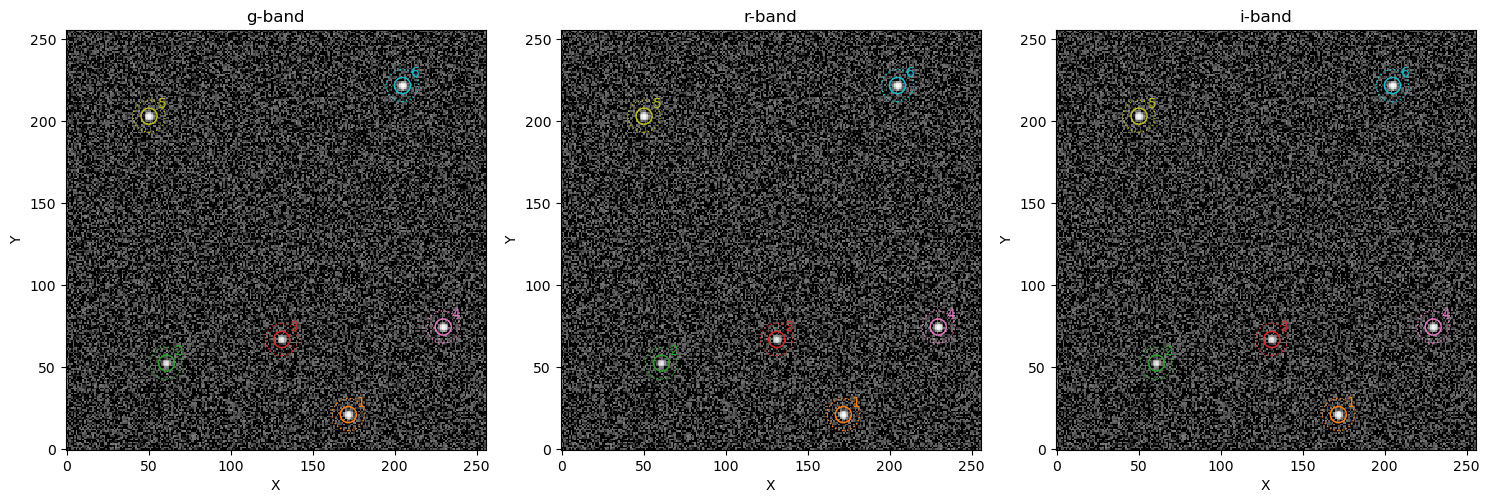

In [9]:
from opticam_new import Reducer

reducer = Reducer(
    data_directory='data/',  # path to the simulated data
    out_directory='reduced/',  # path to where output will be saved
    show_plots=True,
    flat_corrector=flat_corrector  # pass the flat field corrector to the reducer
    )

reducer.initialise_catalogs(overwrite=True)

As we can see, the aperture shadow we saw in the previous example has been eliminated from the stacked catalog image thanks to the `FlatFieldCorrector` object.

That concludes the corrections tutorial for `opticam_new`! Currently, image corrections are limited to flat-field corrections, but we plan to include more complete CCD corrections in future.